# S3E24 Model Tuning
* 3 model ensemble is a blend of these three models
    * Catboost
    * XGBoost
    * LightGBM
* Other models included here but not in ensemble
    * Logistic Regression
    * Random Forest
<p>
* Note: should tune RF elsewhere since it is so slow

# Installs

In [36]:
# scienceplots produces IEEE style plots
!pip install -q scienceplots

# Imports

In [37]:
import os, glob, pathlib
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px

import scienceplots
plt.style.use(['science','no-latex'])  # not sure how to set up latex in kaggle yet.

import warnings
warnings.filterwarnings('ignore')

# Read Data

In [38]:
kaggle_env = False   # TODO: an auto check to see where I am working

if kaggle_env == True:
    root_dir = '/kaggle/input/playground-series-s3e24'
else:
    root_dir = '.'

train = pd.read_csv(root_dir + '/train.csv')
test = pd.read_csv(root_dir + '/test.csv')
ss = pd.read_csv(root_dir + '/sample_submission.csv')

In [39]:
all_features = [col for col in test.columns if 'id' not in col]
int_features = [col for col in test.columns if 'id' not in col and test[col].dtype=='int']
float_features = [col for col in test.columns if test[col].dtype=='float']

features = all_features
features

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries']

# Feature Engineering

In [48]:
train[train['eyesight(left)'] > 9.0] = 0
train[train['eyesight(right)'] > 9.0] = 0

test[test['eyesight(left)'] > 9.0] = 0
test[test['eyesight(right)'] > 9.0] = 0


In [50]:
train['eyesight(right)'].max()

2.0

# Cross Validation

In [51]:
from sklearn.model_selection import train_test_split, StratifiedKFold

folds = 5
seed = 12

In [52]:
# if continuous, change predict_proba to predict
def run_cv_and_predict(train, test, features, model, seed):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0],folds))

    # setup folding strategy
    skf = StratifiedKFold(n_splits=folds,random_state = seed,shuffle=True)
    # Use KFold if target is continuous
    #skf = KFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indices into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:,1]
        fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = roc_auc_score(y_valid,fold_preds)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        #print(f'ROC AUC Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict_proba(test[features])[:,1]
        test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:,cur_fold-1] = test_preds  
        cur_fold +=1
    
    # Print mean fold and oof score 
    oof_score = roc_auc_score(y,oof)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'ROC AUC score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds,fold_scores,oof_score,oof)

# Models

In [53]:
from sklearn.linear_model import LogisticRegression   # try CV too
from sklearn.metrics import roc_auc_score,roc_curve

## Split Data

In [54]:
# start with train-test split
y = train['smoking']
# x_train, x_valid, y_train, y_valid = train_test_split(train[features], y, train_size=0.8, test_size=0.2,
#                                                       random_state=12)

x_test = test[features]

## Baseline Model - Logistic Regression

In [55]:

model_lr = LogisticRegression()#C=10)
preds_lr,scores_lr,oof_score_lr,oof_lr = run_cv_and_predict(train,test,features,model_lr,seed)


# model.fit(x_train,y_train)
# val_preds = model.predict_proba(x_valid)[:,1]  
# score = roc_auc_score(y_valid, val_preds)   # make sure true is first
# print(f'ROC AUC Score = {score:.5f}')


# default lr, no feature engineering, all features, tts = .81622, lb = .81916
# int features = .80181, lb = .80703
# float features = .76748, lb = .77048
# cross validation: .81702, lb = 

ROC AUC score: 0.81740, Stdev: 0.00182, OOF score: 0.81739


### Plot ROC Curve

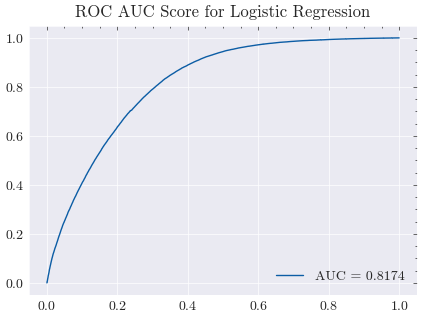

In [56]:
def plot_roc_curve(y_actual,y_preds, model_type='Unspecified'):
    plt.figure(figsize=(5,3.5))
    fpr,tpr,_ = roc_curve(y_actual,y_preds)
    plt.plot(fpr,tpr, label=f'AUC = {np.mean(scores_lr):.5}')
    plt.legend(loc='lower right')
    plt.title(f'ROC AUC Score for {model_type}')
    plt.show()
    
    
plot_roc_curve(y, oof_lr, 'Logistic Regression')

## Random Forest
* Slowest = about 4 min run time

In [57]:
# %%time
# from sklearn.ensemble import RandomForestClassifier

# model_rf = RandomForestClassifier()

# preds_rf,scores_rf,oof_score_rf,oof_rf = run_cv_and_predict(train,test,features,model_rf,seed)

# RF default ROC AUC score: 0.85248, Stdev: 0.00173, OOF score: 0.85247, lb = 
# 4 min run time

## Catboost
* About 2x speed of RF with current config, 2 min run time

## Manual Tuning

In [58]:
%%time
from catboost import CatBoostClassifier

# Round 2: 1100-1500, 100 inc, learning rate: .15,.2,.25,.5, max depth: 7,9,11
# Gradient optuna results: 

results = []

for it in [1200,1400,1600,1800]:
    for lr in [.06, .08,.09,.1,.125,.15,.2]:
        for d in [4, 5,7,9,11]:
            model_cat = CatBoostClassifier(verbose=0,n_estimators=it,learning_rate=lr,max_depth=d,task_type='GPU')
            preds_cat, scores_cat, oof_score_cat, oof_cat = run_cv_and_predict(train,test,features,model_cat,seed)
            print(f'est: {it}, lr: {lr}, depth: {d}, cv score: {np.mean(scores_cat)}')
        
            results.append([it,lr,d,np.mean(scores_cat)])
            
            
# try random ranges instead


# default ROC AUC score: 0.86531, Stdev: 0.00177, OOF score: 0.86529, lb = 
# 2 min run time
# est: 1300, lr: 0.2, depth: 11, cv score: 0.8503321291349358
# ROC AUC score: 0.86520, Stdev: 0.00183, OOF score: 0.86518

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [59]:
# results_df = pd.DataFrame(results,columns=['estimators','learning_rate','max_depth','cv_score'])
# results_df.head()

In [60]:
# TODO: write function to save data automatically
# results_df.to_csv('20231026_cat_tuning.csv')

In [61]:
# max_cv = results_df.cv_score.max()
# results_df[results_df.cv_score == max_cv]

In [62]:
# import plotly.express as px

# fig = px.scatter_3d(results_df, x='estimators', y='max_depth', z='learning_rate',color='cv_score')  # scatter of 3 cols of df
# fig.update_traces(marker={'size': 3})
# fig.show(renderer='notebook')

I like that I can rotate this grid around and look at where things seem to be heading.  From this, my next set will be from 
* estimators: 1100-1500, 100 inc, learning rate: .15,.2,.25,.5, max depth: 7,9,11

 ## Cat tuning with Optuna

In [63]:
import optuna
from optuna.samplers import TPESampler

In [64]:
def objective(trial):
    
    scores = []
    
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 50, 2000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        random_seed=12,
        verbose=False
    )
    
    # do cross validation - 5 folds
    skf = StratifiedKFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:,1]
        fold_score = roc_auc_score(y_valid,fold_preds) 
        scores.append(fold_score)
        #print(f'ROC AUC Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
#         test_preds = model.predict_proba(test[features])[:,1]
#         test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
#         preds[:,cur_fold-1] = test_preds 
        
        cur_fold +=1
    

    return np.mean(scores)


In [65]:
# create the study
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=12)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

In [66]:
# evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# ver1 best: cv = .86574
# make eyesight 9.9 be 0.0, cv = 


Number of finished trials:  100
Best trial:
  Value:  0.8664037848814272
  Params: 
    iterations: 1594
    learning_rate: 0.08597479446270902
    depth: 5
    l2_leaf_reg: 59.431838236102124
    bootstrap_type: Bayesian
    random_strength: 1.7517306213024682e-07
    bagging_temperature: 0.31515216056522827
    od_type: IncToDec
    od_wait: 31


In [67]:
# create model with best hyperparams
best_cat_model = CatBoostClassifier(**trial.params, verbose=False)
best_cat_model.fit(train[features], y)
cat_preds = best_cat_model.predict_proba(x_test)[:,1]

# best of 10 trials = .862

In [68]:
# can also save the model (instead of importing parameters
pickle.dump(best_cat_model, open("catboost_optuna2.pkl", "wb"))


## LightGBM
* super fast ~= 40 sec

In [70]:
%%time
from lightgbm import LGBMClassifier
model_lgbm = LGBMClassifier()

preds_lgbm, scores_lgbm, oof_score_lgbm, oof_lgbm = run_cv_and_predict(train,test,features,model_lgbm,seed)

# default: ROC AUC score: 0.86130, Stdev: 0.00173, OOF score: 0.86128, lb = 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55663, number of negative: 71741
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1889
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436902 -> initscore=-0.253747
[LightGBM] [Info] Start training from score -0.253747
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55663, number of negative: 71742
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

# Submission
* Check submission CV vs LB

In [26]:
ss.smoking = cat_preds
ss.to_csv('submission.csv',index=False)
ss.head(3)

,id,smoking
0,159256,0.514404
1,159257,0.214076
2,159258,0.406073


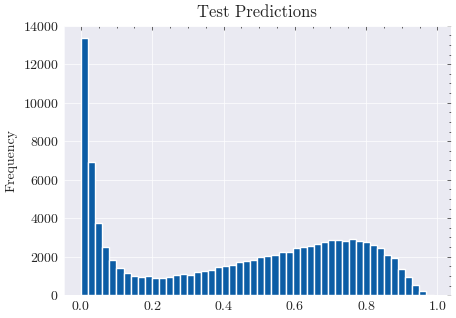

In [27]:
plt.figure(figsize=(5,3.5))
ss.smoking.plot(kind='hist',bins=50)
plt.title('Test Predictions');